# A 3D Fuel Pin Geometry of the SNRE 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import openmc

openmc.Materials.cross_sections = "/home/jimmy/Documents/SNRE_UROP/SNRE/ICL_UROP/dataLibrary/cross_sections.xml"

# Materials definitions
fuel = openmc.Material(name='fuel', temperature=300)
fuel.set_density('g/cm3', 3.64)
fuel.add_nuclide('U235', 0.558, 'wo')
fuel.add_nuclide('U238', 0.042, 'wo')
fuel.add_element('Zr', 1.81, 'wo')
fuel.add_nuclide('C0', 1.23, 'wo')
fuel.add_s_alpha_beta('c_Graphite')

coolant = openmc.Material(name='coolant', temperature=300)
coolant.set_density('atom/b-cm', 1.61317e-3)
coolant.add_element('H', 1.0, 'wo')
coolant.add_s_alpha_beta('c_para_H')

cladding = openmc.Material(name='cladding', temperature=300)
cladding.set_density('g/cm3', 6.73)
cladding.add_element('Zr', 0.88375, 'wo')
cladding.add_nuclide('C0', 0.11625, 'wo')
cladding.add_s_alpha_beta('c_Graphite')

# Materials xml
materials = openmc.Materials([fuel, coolant, cladding])
materials.export_to_xml('./xmlFiles/')

# Geometry definitions
channelRadius = 0.11827
cladOuterRadius = 0.12827
pinPitch = 0.40894
cladOuterThickness = 0.005
hexDuctOuter = 1.905
hexDuctInner = hexDuctOuter - 2*cladOuterThickness
pinLengthInner = 75
pinLengthOuter = pinLengthInner + cladOuterThickness

# Boudaries and outer universe
fuelOut = openmc.Cell(cell_id=200, fill=fuel)

# Top & bottom of the assembly 
assemblyBottom = openmc.ZPlane(surface_id=300, z0=-pinLengthInner)
assemblyTop = openmc.ZPlane(surface_id=301, z0=pinLengthInner)

assemblyHex = openmc.model.hexagonal_prism(edge_length=hexDuctInner / np.sqrt(3.),
                                        orientation='x')

# Top & bottom of the reflector
cladOuterBottom = openmc.ZPlane(surface_id=303, z0=-pinLengthOuter, boundary_type='reflective')
cladOuterTop = openmc.ZPlane(surface_id=304, z0=pinLengthOuter, boundary_type='reflective')

# Reflector hexagon
cladOuterHex = openmc.model.hexagonal_prism(edge_length=hexDuctOuter / np.sqrt(3.), 
                                         orientation='x',
                                         boundary_type='reflective')

assemblyCell = openmc.Cell()
cladOuterCell = openmc.Cell()
cladTopCell = openmc.Cell()
cladBottomCell = openmc.Cell()

assemblyCell.region = assemblyHex & -assemblyTop & +assemblyBottom
cladOuterCell.region = ~assemblyHex & cladOuterHex & -assemblyTop & +assemblyBottom
cladTopCell.region = cladOuterHex & +assemblyTop & -cladOuterTop
cladBottomCell.region = cladOuterHex & -assemblyBottom & +cladOuterBottom

cladOuterCell.fill = cladding
cladTopCell.fill = cladding
cladBottomCell.fill = cladding

# Create universes
fuelOutUni = openmc.Universe(cells=(fuelOut,))
cladOuterUni = openmc.Universe(cells=(cladOuterCell,cladTopCell,cladBottomCell))
rootUni = openmc.Universe()

coolantChannelOuter = openmc.ZCylinder(surface_id=400, r=channelRadius)
cladChannelOuter = openmc.ZCylinder(surface_id=402, r=cladOuterRadius)

coolantChannelCell  = openmc.Cell(cell_id=400, fill=coolant, region=-coolantChannelOuter & -assemblyTop & +assemblyBottom)
cladChannelCell  = openmc.Cell(cell_id=401, fill=cladding, region=+coolantChannelOuter & -cladChannelOuter & -assemblyTop & +assemblyBottom)
fuelChannelCell = openmc.Cell(cell_id=402, fill=fuel, region=+cladChannelOuter & -assemblyTop & +assemblyBottom)

channelUni = openmc.Universe(cells=[fuelChannelCell, cladChannelCell, coolantChannelCell])
# Creating the hexagonal lattice

lat=openmc.HexLattice(name='assembly')
lat.center = (0., 0.)
lat.pitch = (pinPitch,)
lat.outer=fuelOutUni
ring2=[channelUni]*12
ring1=[channelUni]*6
ring0=[channelUni]
lat.universes = [ring2, ring1, ring0]
lat.orientation='x'
assemblyCell.fill = lat

rootUni.add_cells([assemblyCell, cladOuterCell, cladTopCell, cladBottomCell])
geom=openmc.Geometry(rootUni)
geom.export_to_xml('./xmlFiles/')

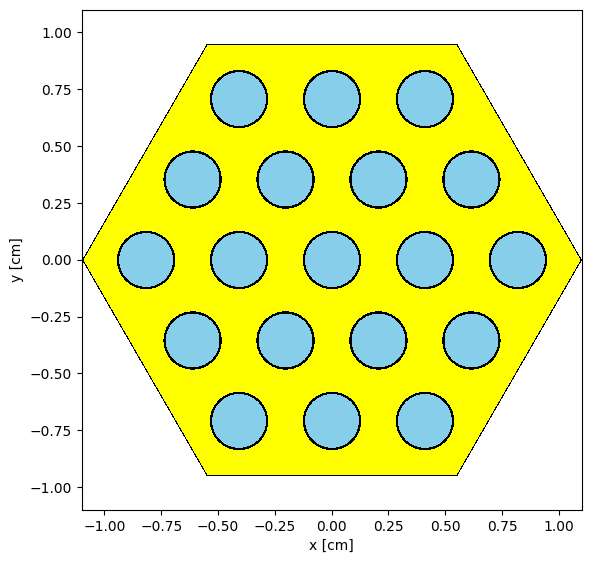

In [2]:
rootUni.plot(origin=(0,0,0),width=(2.2,2.2),color_by='material',colors={fuel: 'yellow', coolant: 'skyblue', cladding: 'black',},pixels=[500,500])

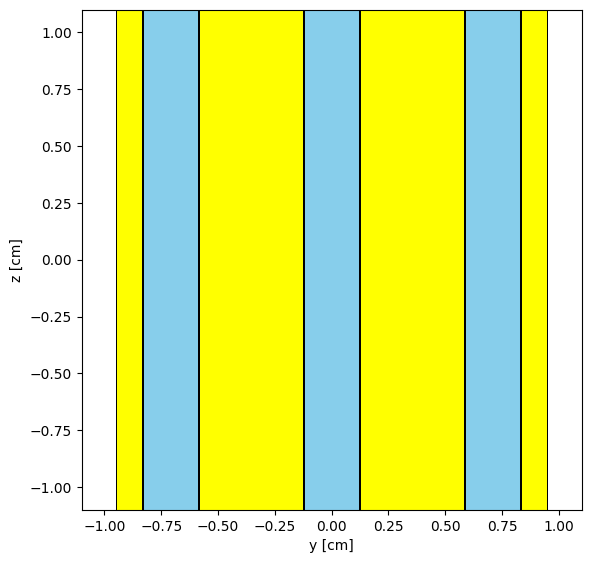

In [3]:

rootUni.plot(basis='yz',origin=(0,0,0),width=(2.2,2.2),color_by='material',colors={fuel: 'yellow', coolant: 'skyblue', cladding: 'black',},pixels=[500,500])

In [4]:
# OpenMC simulation parameters

settings = openmc.Settings()
settings.run_mode = 'eigenvalue'

settings.particles = 500
settings.generations_per_batch = 10
settings.batches = 50
settings.inactive = 20
settings.export_to_xml('./xmlFiles/')

source = openmc.IndependentSource()
source.space = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))

mesh = openmc.RegularMesh()
mesh.dimension = [500, 500]
mesh.lower_left = [-1.1, -1.1]
mesh.upper_right = [1.1, 1.1]

tallies = openmc.Tallies()

fuelAllTally = openmc.Tally(tally_id=1)
fuelAllTally.filters = [openmc.MeshFilter(mesh)]
fuelAllTally.scores = ['flux', 'fission']
tallies.append(fuelAllTally)

fuelThermalTally = openmc.Tally(tally_id=2)
fuelThermalTally.filters = [openmc.MeshFilter(mesh), openmc.EnergyFilter([0,0.1])]
fuelThermalTally.scores = ['flux', 'fission']
tallies.append(fuelThermalTally)

fuelFastTally = openmc.Tally(tally_id=3)
fuelFastTally.filters = [openmc.MeshFilter(mesh), openmc.EnergyFilter([0.1,1e6])]
fuelFastTally.scores = ['flux', 'fission']
tallies.append(fuelFastTally)

tallies.export_to_xml('./xmlFiles/')

openmc.run(path_input='./xmlFiles/')

/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################